# 0. Standard imports

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
sys.path.append('/Users/khalilouardini/Desktop/projects/cascVI/scvi')

***import ete3 Tree***

In [4]:
from ete3 import Tree

#tree_name = "/Users/khalilouardini/Desktop/projects/scVI/scvi/data/Cassiopeia_trees/3726_NT_T1_tree.processed.collapsed.tree"
#tree_name = "/Users/khalilouardini/Desktop/projects/scVI/scvi/data/Cassiopeia_trees/tree_test.txt"
#tree = Tree(tree_name, 1)

tree = Tree()
tree.populate(20)

leaves = tree.get_leaves()

for i, n in enumerate(tree.traverse('levelorder')):
    n.add_features(index=i)
    if not n.is_leaf():
        n.name = str(i)

In [5]:
# Data
from anndata import AnnData
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from dataset.tree import TreeDataset, GeneExpressionDataset
from dataset.poisson_glm import Poisson_GLM
from dataset.ppca import PPCA
from dataset.anndataset import AnnDatasetFromAnnData

# Models
from models import *;
import scanpy as sc
from inference.tree_inference import TreeTrainer
from inference.inference import UnsupervisedTrainer
from inference import posterior
from models.treevae import TreeVAE

# Utils
from utils.data_util import get_leaves, get_internal
from utils.metrics import ks_pvalue, accuracy_imputation, correlations, correlations2, knn_purity, knn_purity_stratified
from utils.plots_util import plot_histograms, plot_scatter_mean, plot_ecdf_ks, plot_density, plot_embedding
from utils.plots_util import plot_losses, plot_elbo, plot_common_ancestor, plot_one_gene, training_dashboard
from utils.baselines import avg_weighted_baseline, scvi_baseline, scvi_baseline_z, cascvi_baseline_z

# 1. Simulations (Gaussian Likelihood model)

We assume that the latent variables $z \in \mathbb{R}^{N x D}$ are gaussian (correlated). A phylogenetic tree $\tau$ (with $N$ nodes) encodes the covariance $\Sigma$ of $z$. 

$$\mathbf{z}=(z_1, ..., z_N) \sim \mathcal{N}(0, \Sigma)$$

$z$ is partitionned into two groups:

- the leaves $\mathcal{L} = {1, ..., L}$
- the internal nodes $\mathcal{I} = {L + 1, ..., N}$

***

***We describe the generative model***:

Consider a dataset of $ X={x_n}_{n=1}^{L} $ (also partitioned such that $1, ..., N = \mathcal{L} \bigcup \mathcal{I}$) such that $x_n \in \mathbb{R}^{P}$. We aim to represent each $x_n$ under a latent variable $z_n \in \mathbb{R}^{D}$ with  with $D << P$ lower dimension. 
We only observe data at the leaves. the generative model is defined $\forall n \in \mathcal{L}$

The set of principal axes $W$ relates the latent variables to the data.

The corresponding data point is generated via a projection:

$$
\forall n \in \mathcal{L}, x_n =  W z_n + e_n
$$

with $W \in \mathbb{R}^{P x D}$ and $e_n \sim \mathcal{N}(0, \sigma^2 I_P)$. Thus:


$$
\forall n \in \mathcal{L},  x_n | z_n \sim \mathcal{N}(W z_n, \sigma^2 I_P)
$$

After marginalization

$$
\forall n \in \mathcal{L}, x_n \sim \mathcal{N}(0, W^T W + \sigma^2 I_P)
$$

The posterior $p(z_n|x_n)$ for each $n$ is also ***tractable***, indeed

$\begin{pmatrix} x_n \\ z_n \end{pmatrix} = \begin{pmatrix} W z_n + e \\ z_n \end{pmatrix}$ is a gaussian vector (because for $a \in \mathbb{R}$, $b \in \mathbb{R}$, $a(W z_n + e) + bz_n$ is still gaussian) such that:

$$
\begin{pmatrix} x_n \\ z_n \end{pmatrix} \sim \mathcal{N}(\begin{pmatrix} 0 \\ 0 \end{pmatrix}, \begin{pmatrix} W^T W + \sigma^2 I_P  & W\Sigma_n \\ (W\Sigma_n)^T & \Sigma_n \end{pmatrix})
$$

where $\Sigma_n$ is the marginalized covariance $\Sigma$ of $z_n$

Therefore we can use the conditioning formula to infer the mean and the covariance of the (gaussian) posterior $p(z_n|x_n)$:

$$
\mu_{z_n|x_n} = (W\Sigma_{n}(W^{T} W + \sigma^{2} I_{P})^{-1}\Sigma_{n}^{T}W^{T}) x_{n} \\
\Sigma_{z_n|x_n} = \Sigma_n - W\Sigma_{n}(W^{T} W + \sigma^{2} I_{P})^{-1}\Sigma_{n}^{T}W^{T}
$$

***

***Imputation at internal nodes***

Let $j \in \mathcal{I}$, and $X_{\mathcal{L}} = {x_1, ... x_L}$ the set of leaves.
We want to infer $p(x_j|X_{\mathcal{L}})$. If we consider that the data at the internal nodes is "seen" and that the generative model is also known $\forall n \in \mathcal{I}$, we could easily (and accurately) compute $p(x_j|X_{\mathcal{L}})$ by using the gaussian conditioning formula on the gaussian vector:

$$
\begin{pmatrix} x_j \\ X_{\mathcal{L}} \end{pmatrix}
$$

In the case of unseen data at the internal nodes, one can estimate the posterior predictive density:

1. $$
p(x_j|X_{\mathcal{L}}) = p(x_j|x_1, ..., x_L) = \int p(x_j|z_j)p(z_j|z_1,...,z_L)\prod_{i=1}^{L}p(z_i|x_i)(dz_j,dz_1,...,dz_L)
$$

Therefore:
$$
p(x_j|x_1, ..., x_L) \approx  p(x_j|z_j)p(z_j|z_1,...,z_L)\prod_{i=1}^{L}p(z_i|x_i)
$$

$$
p(x_j|x_1, ..., x_L) \approx  \mathcal{N}(x_j|Wz_j, \sigma^2I_P)  \mathcal{N}(z_j|\mu_{j|\mathcal{I}}, \Sigma_{j|\mathcal{I}}) \prod_{i=1}^{L} \mathcal{N}(z_i|\mu_{z_i|x_i}, \Sigma_{z_i|x_i})
$$

2. $ p(x_j|X_{\mathcal{L}}) = Wp(z_j|X_{\mathcal{L}}) + p(e_j)$

In [6]:
print(tree)


         /-aaaaaaaaaa
      /-|
     |   \-aaaaaaaaab
   /-|
  |  |   /-aaaaaaaaac
  |   \-|
  |      \-aaaaaaaaad
  |
--|      /-aaaaaaaaae
  |   /-|
  |  |  |   /-aaaaaaaaaf
  |  |   \-|
  |  |      \-aaaaaaaaag
  |  |
   \-|      /-aaaaaaaaah
     |   /-|
     |  |  |   /-aaaaaaaaai
     |  |   \-|
     |  |      \-aaaaaaaaaj
     |  |
      \-|      /-aaaaaaaaak
        |   /-|
        |  |  |   /-aaaaaaaaal
        |  |   \-|
        |  |      \-aaaaaaaaam
         \-|
           |      /-aaaaaaaaan
           |   /-|
           |  |   \-aaaaaaaaao
            \-|
              |   /-aaaaaaaaap
               \-|
                 |   /-aaaaaaaaaq
                  \-|
                    |   /-aaaaaaaaar
                     \-|
                       |   /-aaaaaaaaas
                        \-|
                           \-aaaaaaaaat


In [7]:
d = 5
p = 100
vis = True
leaves_only = False
var = 1.0
sigma_scale = 1.0

ppca = PPCA(tree, p, d, vis, leaves_only, var, sigma_scale)

ppca.simulate_latent()

***Marginalization***

In [8]:
ppca.leaves_covariance_z.shape

(100, 100)

In [78]:
ppca.simulate_normal()

In [79]:
lik_tree = ppca.likelihood_obs(leaves_only=False)
lik_leaves = ppca.likelihood_obs(leaves_only=True)

print("Log-Likelihood of the tree {}".format(lik_tree))
print("LogLikelihood of the leaves {}".format(lik_leaves))

Log-Likelihood of the tree -6130.980496595257
LogLikelihood of the leaves -3133.6575982758677


***Get data***

In [80]:
# Latent vectors
leaves_z, _, _ = get_leaves(ppca.z, ppca.mu, tree)

#FIXED training set
leaves_X, leaves_idx, mu = get_leaves(ppca.X, ppca.mu, tree)

# internal nodes data (for imputation)
internal_X, internal_idx, internal_mu = get_internal(ppca.X, ppca.mu, tree)

leaves_X.shape, mu.shape, internal_X.shape, internal_mu.shape, leaves_z.shape

((20, 100), (20, 100), (19, 100), (19, 100), (20, 5))

***Posterior Distributions***

evidence

In [81]:
evidence_leaves = ppca.get_evidence_leaves_levelorder(X=ppca.X, dim=ppca.dim)
evidence_leaves.shape

(2000,)

Leaves covariance

In [82]:
ppca.compute_leaves_covariance()

Posterior mean and covariance

In [83]:
posterior_mean, posterior_cov = ppca.compute_posterior()

Posterior predictive density 

In [84]:
predictive_mean, predictive_cov = ppca.compute_posterior_predictive()

## Preliminary: Baselines

***Baseline 1: Unweighted Average of gene expression in Clade***

The simple idea here is to impute the value of an internal node, with the (un)weighted average of the gene expression values of the leaves, taking the query internal node as the root of the subtree.

In [99]:
weighted = True
imputed_avg = avg_weighted_baseline(tree=tree, 
                                    weighted=True, 
                                    X=ppca.X,
                                    rounding=False)

#get internal nodes
avg_X = np.array([x for x in imputed_avg.values()]).reshape(-1, ppca.X.shape[1])
internal_avg_X, _, _ = get_internal(avg_X, ppca.mu, tree)

***Baseline 2: (groundtruth) posterior predictive density***

In [100]:
imputed_ppca = {}
for n in tree.traverse('levelorder'):
    if not n.is_leaf():
        samples = np.array([np.random.multivariate_normal(mean=predictive_mean[n.name],
                                                            cov=predictive_cov[n.name])
                           for i in range(20)])
        imputed_ppca[n.name] = np.mean(samples, axis=0)

internal_ppca_X = np.array([x for x in imputed_ppca.values()]).reshape(-1, ppca.X.shape[1])

//anaconda3/envs/berkeley/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  


***Baseline 3: Message Passing Oracle***


i.e, 

1. sample from $z_1, ..., z_n \sim p(z_1, ..., z_n|x_1, ..., x_n)$ (conditionning formula)
2. impute $z_i \sim p(z_i | z_1, ..., z_n)$ (Message Passing)
3. Decode $p(x_i|z_i) = W z_i + \sigma^2 I_P$ (Generative model)

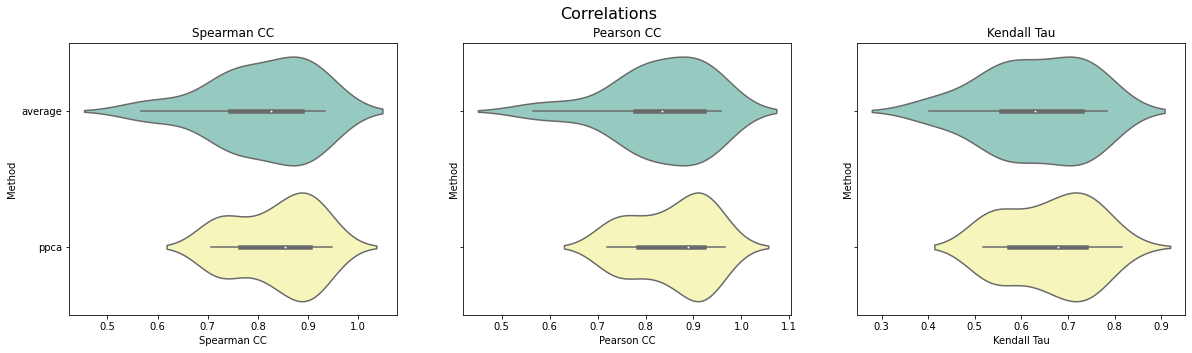

In [101]:
data = {'groundtruth': internal_X.T, 'average': internal_avg_X.T, 'ppca':internal_ppca_X.T}
df1 = correlations2(data, 'None', True)
df1.head(5)
plt.show()

In [103]:
predictive_mean['0'].shape, predictive_cov['0'].shape

((100,), (100, 100))

# 2. Fitting CascVI

In [ ]:
import scanpy as sc

# anndata + gene and celle filtering
adata = AnnData(leaves_X)
adata.obs_names = [n.name for n in list(tree.get_leaves())]
#sc.pp.filter_genes(adata, min_counts=3)
#sc.pp.filter_cells(adata, min_counts=0)

In [ ]:
scvi_dataset = AnnDatasetFromAnnData(adata)
scvi_dataset.initialize_cell_attribute('barcodes', adata.obs_names)

***Create a TreeDataset object***

In [ ]:
# treeVAE
import copy

tree_bis = copy.deepcopy(tree)
cas_dataset = TreeDataset(scvi_dataset, tree=tree_bis)
cas_dataset

# No batches beacause of the message passing
use_batches = False
use_cuda = False

***Initialize model***

In [ ]:
#var = 1.0
vae = TreeVAE(cas_dataset.nb_genes,
              tree = tree,
              n_batch=cas_dataset.n_batches * use_batches,
              n_latent=glm.latent,
              n_hidden=128,
              n_layers=1,
              reconstruction_loss='poisson',
              prior_t = var,
              ldvae = False
             )

***Hyperparameters***

In [ ]:
n_epochs = 400
lr = 1e-3
lambda_ = 1.0

***trainer***

In [ ]:
freq = 10
trainer = TreeTrainer(
    model = vae,
    gene_dataset = cas_dataset,
    lambda_ = lambda_,
    train_size=1.0,
    test_size=0,
    use_cuda=use_cuda,
    frequency=freq,
    n_epochs_kl_warmup=None
)

***Start training***

In [ ]:
trainer.train(n_epochs=n_epochs,
              lr=lr)

***Loss Functions***

In [ ]:
training_dashboard(trainer, vae.encoder_variance)

### 3. Posterior and MV imputation

In [ ]:
full_posterior = trainer.create_posterior(trainer.model, cas_dataset, trainer.clades,
                                indices=np.arange(len(cas_dataset))
                                         )

***Missing Value imputation By Posterior Predictive sampling***

In [ ]:
empirical_l = np.mean(np.sum(glm.X, axis=1))

# CascVI impitations
imputed = {}
imputed_z = {}
imputed_gt = {}

for n in tree.traverse('levelorder'):
    if not n.is_leaf():
        imputed[n.name], imputed_z[n.name] = full_posterior.imputation_internal(n.name,
                                                            give_mean=False,
                                                            library_size=empirical_l
                                                           )
        imputed_gt[n.name] = glm.X[n.index]

In [ ]:
imputed_X = [x for x in imputed.values()]
imputed_X = np.array(imputed_X).reshape(-1, cas_dataset.X.shape[1])
#plot_histograms(imputed_X, "Histogram of CasscVI imputed gene expression data")

***CascVI Baseline 1 (Average of reconstructions)***

In [ ]:
imputed_cascvi_1 = scvi_baseline(tree, full_posterior, True)

***CascVI Baseline 2 (Reconstruction of Averaged latent space)***

In [ ]:
imputed_cascvi_2, imputed_cascvi_2_z = scvi_baseline_z(tree=tree,
                                   model=vae,
                                   posterior=full_posterior,
                                   weighted=True,
                                   n_samples_z=1,
                                   library_size=empirical_l
                                  )

# 4. Baselines

***Baseline 1: Unweighted Average of gene expression in Clade***

The simple idea here is to impute the value of an internal node, with the (un)weighted average of the gene expression values of the leaves, taking the query internal node as the root of the subtree.

In [ ]:
weighted = True
imputed_avg = avg_weighted_baseline(tree, True, glm.X)

#get internal nodes
avg_X = np.array([x for x in imputed_avg.values()]).reshape(-1, glm.X.shape[1])
internal_avg_X, _, _ = get_internal(avg_X, glm.mu, tree)
#plot_histograms(avg_X,
#               'Histograms of imputed GE values with the average baseline')

***Baseline 2: (Un)weighted Average of decoded latent vectors, with scVI***

We use the same averaging of the subtrees leaves in **Baseline 1**, only this time, the gene expression data is recovered with scVI

In [ ]:
# anndata
gene_dataset = GeneExpressionDataset()
gene_dataset.populate_from_data(leaves_X)

In [ ]:
n_epochs = 400

vae_scvi = VAE(gene_dataset.nb_genes,
                  n_batch=cas_dataset.n_batches * use_batches,
                  n_hidden=128,
                  n_layers=1,
                  reconstruction_loss='poisson',
                  n_latent=glm.latent)

trainer_scvi = UnsupervisedTrainer(model=vae_scvi,
                              gene_dataset=gene_dataset,
                              train_size=1.0,
                              use_cuda=use_cuda,
                              frequency=10,
                              n_epochs_kl_warmup=None)

# train scVI
trainer_scvi.train(n_epochs=n_epochs, lr=1e-3) 
                                        
elbo_train_scvi = trainer_scvi.history["elbo_train_set"]
x = np.linspace(0, 100, (len(elbo_train_scvi)))
plt.plot(np.log(elbo_train_scvi), 
         label="train", color='blue',
         linestyle=':',
         linewidth=3
        )
plt.xlabel('Epoch')
plt.ylabel("ELBO")
plt.legend()
plt.title("Train history scVI")
plt.show()

***scVI Baseline 1 (Average of reconstructions)***

In [ ]:
scvi_posterior = trainer_scvi.create_posterior(model=vae_scvi,
                                              gene_dataset=gene_dataset
                                              )

imputed_scvi, imputed_scvi_z = scvi_baseline(tree=tree, 
                                             posterior=scvi_posterior, 
                                             weighted=True,
                                            give_latent=True,
                                            n_samples_z=1)

scvi_latent = scvi_posterior.get_latent()[0]
scvi_latent.shape

***scVI Baseline 2 (Decoded Average Latent space)***

In [ ]:
library_size = np.mean(np.sum(glm.X, axis=1))
imputed_scvi_2, imputed_scvi_2_z = scvi_baseline_z(tree=tree,
                                 model=vae_scvi,
                                 posterior=scvi_posterior,
                                 weighted=True,
                                 n_samples_z=1,
                                 library_size=library_size
                                )


***CascVI Baseline 3***

In [ ]:
imputed_cascvi_3 = cascvi_baseline_z(tree=tree,
                                   model=vae_scvi,
                                   latent=imputed_z,
                                   library_size=library_size
                                  )

***(Bonus) MP Imputation with scVI latent space***

In [ ]:
empirical_l = library_size

# CascVI impitations
imputed_bis = {}
imputed_z_bis = {}

for n in tree.traverse('levelorder'):
    if not n.is_leaf():
        imputed_bis[n.name], imputed_z_bis[n.name] = full_posterior.imputation_internal(n.name,
                                                            give_mean=False,
                                                            library_size=empirical_l,
                                                            other_posterior=scvi_posterior
                                                           )

# 5. Likelihood Ratio

In [ ]:
cascvi_latent = full_posterior.get_latent()[0]
scvi_latent.shape, cascvi_latent.shape

In [ ]:
vae.initialize_visit()
vae.initialize_messages(scvi_posterior.get_latent()[0], cas_dataset.barcodes, scvi_latent.shape[1])
vae.perform_message_passing((vae.tree & vae.root), scvi_latent.shape[1], False)
mp_lik_scvi = vae.aggregate_messages_into_leaves_likelihood(d, add_prior=True)
print("Likelihood of scVI encodings: ", mp_lik_scvi.item())

In [ ]:
vae.initialize_visit()
vae.initialize_messages(full_posterior.get_latent()[0], cas_dataset.barcodes, cascvi_latent.shape[1])
vae.perform_message_passing((vae.tree & vae.root), cascvi_latent.shape[1], False)
mp_lik_cascvi = vae.aggregate_messages_into_leaves_likelihood(d, add_prior=True)
print("Likelihood of cascVI encodings: ", mp_lik_cascvi.item())

In [ ]:
# Likelihood ratio
lambda_ = (mp_lik_cascvi - mp_lik_scvi)
print("Likelihood Ratio:", lambda_)

# 6. Latent Space Analysis

***Message Passing on "ground truth" latent space***

In [ ]:
from utils.baselines import construct_latent
empirical_l = library_size

# CascVI impitations
imputed_real = {}
imputed_z_real = {}

for n in tree.traverse('levelorder'):
    if not n.is_leaf():
        imputed_real[n.name], imputed_z_real[n.name] = full_posterior.imputation_internal(n.name,
                                                            give_mean=False,
                                                            library_size=empirical_l,
                                                            known_latent=leaves_z
                                                           )
full_real_latent = construct_latent(tree, leaves_z, imputed_z_real)

#print("Real latent space")
#plot_common_ancestor(tree_bis,
#                     full_real_latent,
#                     embedding='umap',
#                     give_labels=False
#                             )

In [ ]:
mu_real = np.clip(a=np.exp(full_real_latent @ glm.W + glm.beta),
                         a_min=0,
                         a_max=5000
                  )

X_real = np.asarray(np.random.poisson(mu_real), dtype=np.float64)
internal_X_real, _, _ = get_internal(X_real, mu_real, tree)
internal_X_real.shape

***CascVI***

In [ ]:
# Merge internal nodes and leaves
full_cascvi_latent = construct_latent(tree, cascvi_latent, imputed_z)


#print("CascVI latent space")
#plot_common_ancestor(tree_bis,
#                     full_cascvi_latent,
#                     embedding='umap',
#                     give_labels=False
#                             )



In [ ]:
full_cascvi_latent_2 = construct_latent(tree, cascvi_latent, imputed_cascvi_2_z)

#print("CascVI + averaging latent space")
#plot_common_ancestor(tree_bis,
#                     full_cascvi_latent_2,
#                     embedding='umap',
#                     give_labels=False
#                             )

***scVI***

In [ ]:
# Merge internal nodes and leaves
full_scvi_latent = construct_latent(tree, scvi_latent, imputed_scvi_2_z)

#print("scVI latent space")
#plot_common_ancestor(tree_bis,
#                 full_scvi_latent,
#                 embedding='umap',
#                 give_labels=False
#                    )

***scVI + Message Passing***

In [ ]:
# Merge internal nodes and leaves
full_scvi_latent_2 = construct_latent(tree, scvi_latent, imputed_z_bis)

#print("scVI latent space + Message passing")
#plot_common_ancestor(tree,
#                 full_scvi_latent_2,
#                 embedding='umap',
#                 give_labels=False
#                    )

In [ ]:
full_scvi_latent_2.shape

***k-NN purity***

Leaves only

In [ ]:
print("Leaves Only")
scores = knn_purity(max_neighbors=50,
              data=[leaves_z, scvi_latent, cascvi_latent],
              plot=True)

Internal nodes only

In [ ]:
print("Internal nodes Only")
internal_z, internal_idx, internal_mu = get_internal(glm.z, glm.mu, tree)
internal_scvi_z, _, _ = get_internal(full_scvi_latent, glm.mu, tree)
internal_scvi_z_2, _, _ = get_internal(full_scvi_latent_2, glm.mu, tree)
internal_cascvi_z, _, _ = get_internal(full_cascvi_latent, glm.mu, tree)
internal_cascvi_z_2, _, _ = get_internal(full_cascvi_latent_2, glm.mu, tree)

scores = knn_purity(max_neighbors=50,
              data=[internal_z, internal_scvi_z, internal_scvi_z_2, internal_cascvi_z, internal_cascvi_z_2],
              plot=True
              )

Full tree

In [ ]:
print("Full tree")
scores = knn_purity(max_neighbors=50,
              data=[glm.z, full_scvi_latent, full_scvi_latent_2, full_cascvi_latent, full_cascvi_latent_2],
              plot=True)

***Stratified k-NN purity***

In [ ]:
for k in [2, 5, 10, 20, 35, 50]:
    print("For {} neighbors".format(k))
    if k == 10:
        min_depth = 3
    elif k == 20:
        min_depth = 4
    elif k == 35:
        min_depth = 6
    elif k == 50:
        min_depth = 7
    else:
        min_depth = 2
    scores = knn_purity_stratified(n_neighbors=k,
                                   tree=tree,
                                   data=[glm.z, full_scvi_latent, full_scvi_latent_2, full_cascvi_latent, full_cascvi_latent_2],
                                   min_depth=min_depth,
                                   plot=True)

# 7. Variance analysis

***Empirical Variance of observed***

In [ ]:
# Get empirical variance of the encoder
qz_v_norm = full_posterior.empirical_qz_v(
                                    n_samples=1000,
                                    norm=True)

In [ ]:
var_dict = {}
node_sizes = []

for i, n in enumerate(tree.traverse('levelorder')):
    if not n.is_leaf():
        # if n is an internal node, we get the variance from the prior
        z = full_posterior.get_latent(give_mean=False)[0]
        _, v_nu = vae.posterior_predictive_density(query_node=n.name, 
                                                  evidence=z) 
        
        var_dict[n.name] = str(np.around(a=v_nu,
                             decimals=4)
                              )
        node_sizes.append(np.around(a=v_nu,
                             decimals=4)
                         )
    else:
        idx = leaves_idx.index(n.index)
        # if n is a leaf, we get the variance from the encoder
        
        # variational distribution variance
        
        # Empirical variance
        var_dict[n.name] = str(np.around(a=qz_v_norm[idx],
                                 decimals=4)
                             )
        node_sizes.append(np.around(a=qz_v_norm[idx],
                                 decimals=4) 
                         )

In [ ]:
var_dict

***Plot variance***

In [ ]:
plot_one_gene(tree=tree, 
              X=imputed_X, 
              g=0, 
              node_sizes=[int(n*10000) for n in node_sizes], #+[1000]
              var='latent',
              size=1000,
              show_index=True,
              save_fig=True,
              figsize=(180, 100)
             )

print("CascVI: Imputations + Variance analysis")

# 7. Evaluation

***CPM Normalization (for sample-sample correlation)***

get imputations into an array

In [ ]:
internal_scvi_X = np.array([x for x in imputed_scvi.values()]).reshape(-1, glm.X.shape[1])
internal_scvi_X_2 = np.array([x for x in imputed_scvi_2.values()]).reshape(-1, glm.X.shape[1])
internal_cascvi_X = np.array([x for x in imputed_cascvi_1.values()]).reshape(-1, glm.X.shape[1])
internal_cascvi_X_2 = np.array([x for x in imputed_cascvi_2.values()]).reshape(-1, glm.X.shape[1])
#internal_cascvi_X_3 = np.array([x for x in imputed_cascvi_3.values()]).reshape(-1, glm.X.shape[1])
#internal_cascvi_X_3 = np.array([x for x in imputed_real.values()]).reshape(-1, glm.X.shape[1])
internal_cascvi_X_3 = internal_X_real

internal_scvi_X.shape, internal_scvi_X_2.shape, internal_cascvi_X.shape, internal_cascvi_X_2.shape, internal_cascvi_X_3.shape

In [ ]:
from sklearn.preprocessing import normalize

norm_internal_X = sc.pp.normalize_total(AnnData(internal_X), target_sum=1e4, inplace=False)['X'] 
norm_scvi_X = sc.pp.normalize_total(AnnData(internal_scvi_X), target_sum=1e4, inplace=False)['X']
norm_scvi_X_2 = sc.pp.normalize_total(AnnData(internal_scvi_X_2), target_sum=1e4, inplace=False)['X']
norm_avg_X = sc.pp.normalize_total(AnnData(internal_avg_X), target_sum=1e4, inplace=False)['X']
norm_imputed_X = sc.pp.normalize_total(AnnData(imputed_X), target_sum=1e4, inplace=False)['X']
norm_cascvi_X = sc.pp.normalize_total(AnnData(internal_cascvi_X), target_sum=1e4, inplace=False)['X']
norm_cascvi_X_2 = sc.pp.normalize_total(AnnData(internal_cascvi_X_2), target_sum=1e4, inplace=False)['X']
norm_cascvi_X_3 = sc.pp.normalize_total(AnnData(internal_cascvi_X_3), target_sum=1e4, inplace=False)['X']

norm_internal_X.shape

## I. Sample-Sample Correlations

***1. Sample-Sample correlation (Without Normalization)***

We will use Scipy to compute a nonparametric rank correlation between the imputed and the groundtruth profiles. The correlation is based on the Spearman Correlation Coefficient.

In [ ]:
data = [internal_X.T, imputed_X.T, internal_avg_X.T ,internal_scvi_X.T,
        internal_scvi_X_2.T, internal_cascvi_X.T, internal_cascvi_X_2.T, internal_cascvi_X_3.T]
df1 = correlations(data, 'None', True)
df1.head(5)
plt.show()

***2. Sample-Sample correlation (With ScanPy Normalization)***

In [ ]:
data = [norm_internal_X.T, norm_imputed_X.T, norm_avg_X.T ,norm_scvi_X.T,
        norm_scvi_X_2.T, norm_cascvi_X.T, norm_cascvi_X_2.T, norm_cascvi_X_3.T]
df2 = correlations(data, 'None', True)
df2.head(5)
plt.show()


## II. Gene-Gene Correlations

***1. Gene-Gene correlation (without Normalization)***

In [ ]:
data = [internal_X, imputed_X, internal_avg_X ,internal_scvi_X,
        internal_scvi_X_2, internal_cascvi_X, internal_cascvi_X_2, norm_cascvi_X_3]
df3 = correlations(data, 'None', True)
df3.head(5)
plt.show()

***2. Gene-Gene correlation (With Normalization)***

In [ ]:
data = [norm_internal_X, norm_imputed_X, norm_avg_X ,
        norm_scvi_X, norm_scvi_X_2, norm_cascvi_X, internal_cascvi_X_2,
       internal_cascvi_X_3]

df4 = correlations(data, 'None', True)
df4.head(5)
plt.show()

***3. Gene-Gene correlation (With Rank Normalization)***

In [ ]:
data = [internal_X, imputed_X, internal_avg_X ,
        internal_scvi_X, internal_scvi_X_2, internal_cascvi_X, internal_cascvi_X_2,
       internal_cascvi_X_3
       ]

df5 = correlations(data, 'rank', True)
df5.head(5)
plt.show()

***4. Gene-Gene correlation (With ScanPy + Rank Normalization)***

In [ ]:
data = [norm_internal_X, norm_imputed_X, norm_avg_X ,
        norm_scvi_X, norm_scvi_X_2, norm_cascvi_X, norm_cascvi_X_2, norm_cascvi_X_3]
df = correlations(data, 'rank', True)
df.head(5)
plt.show()

### III. Table Summary

In [ ]:
columns = ["Method", "Spearman CC", "Pearson CC", "Kendall Tau"]
data = [df1, df2, df3, df4, df5]

tables = [[] for i in range(len(data))]

#task = ["Sample-Sample (None)", "Sample-Sample (CPM)", "Gene-Gene (None)", 
           #"Gene-Gene(CPM)", "Gene-Gene (Rank)" ]

for (df, t) in zip(data, tables):
    for m in np.unique(df.Method):
        sub_df = np.round(df[df['Method'] == m].mean(), decimals=3)
        t.append([m, sub_df['Spearman CC'], sub_df['Pearson CC'], sub_df['Pearson CC']])
        
# Create and style Data Frames
df_table1 = pd.DataFrame(tables[0], columns=columns)
df_table2 = pd.DataFrame(tables[1], columns=columns)
df_table3 = pd.DataFrame(tables[2], columns=columns)
df_table4 = pd.DataFrame(tables[3], columns=columns)
df_table5 = pd.DataFrame(tables[4], columns=columns)

In [ ]:
print(" >>> Sample-Sample | No Normalization <<<")
df_table1.head(10)

In [ ]:
print(">>> Sample-Sample | CPM Normalization <<<")
df_table2.head(10)

In [ ]:
print(">>> Gene-Gene | No Normalization <<<")
df_table3.head(10)

In [ ]:
print(">>> Gene-Gene | CPM Normalization <<<")
df_table4.head(10)

In [ ]:
print(">>> Gene-Gene | Rank Normalization <<<")
df_table5.head(10)

# 8. Exploratory grapghical analysis

***Box plot (Samples)***

In [ ]:
import random
import seaborn as sns

n_samples = 10
idx = random.sample(range(1, 300), n_samples)
n_rows = 2
n_cols = int(n_samples / 2)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(30, 12))

h = 0
for i in range(n_rows):
    for j in range(n_cols):
        k = idx[h]
        h += 1
        # stack arrrays
        data_boxplot = np.vstack([np.log(1 + norm_internal_X[k]), np.log(1 + norm_imputed_X[k]),
          np.log(1 + norm_avg_X[k]), np.log(1 + norm_scvi_X[k]),
           np.log(1 + norm_cascvi_X[k])]).T
        
        # data frame
        df_boxplot = pd.DataFrame(data=data_boxplot,
                          columns=['Ground truth', 'CascVI', 'Avg', 'Avg scVI', 'Avg CascVI'])
        
        sns.boxplot(ax=ax[i][j], data=df_boxplot, orient="v", palette="Set2", showfliers=True)
        ax[i][j].set_title('Sample ' + str(k))

fig.suptitle("Boxplots of gene expression values")
plt.show()

***Box plot (Genes)***

In [ ]:
import random
import seaborn as sns

n_samples = 10
idx = random.sample(range(1, 1000), n_samples)
n_rows = 2
n_cols = int(n_samples / 2)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(30, 12))

h = 0
for i in range(n_rows):
    for j in range(n_cols):
        k = idx[h]
        h += 1
        # stack arrrays
        data_boxplot = np.vstack([np.log(1 + norm_internal_X[:, k]), np.log(1 + norm_imputed_X[:, k]),
          np.log(1 + norm_avg_X[:, k]), np.log(1 + norm_scvi_X[:, k]),
           np.log(1 + norm_cascvi_X[:, k])]).T
        
        # data frame
        df_boxplot = pd.DataFrame(data=data_boxplot,
                          columns=['Ground truth', 'CascVI', 'Avg', 'Avg scVI', 'Avg CascVI'])
        
        sns.boxplot(ax=ax[i][j], data=df_boxplot, orient="v", palette="Set2", showfliers=True)
        ax[i][j].set_title('Gene ' + str(k))

fig.suptitle("Boxplots of gene expression values")
plt.show()

***Density plots***

In [ ]:
import random
import seaborn as sns

n_samples = 12
idx = random.sample(range(1, 1000), n_samples)
n_rows = 3
n_cols = int(n_samples / n_rows)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(35, 15))

h = 0
for i in range(n_rows):
    for j in range(n_cols):
        k = idx[h]
        h += 1
        # density plots
        sns.distplot(ax=ax[i][j], a=np.log(1 + norm_imputed_X[:, k]), hist=False,
                     kde=True, kde_kws={'shade': True}, label='cascVI')
        sns.distplot(ax=ax[i][j], a=np.log(1 + norm_internal_X[:, k]), hist=False,
                     kde=True, kde_kws={'shade': True}, label='groundtruth')
        sns.distplot(ax=ax[i][j], a=np.log(1 + norm_scvi_X[:, k]), hist=False,
                     kde=True, kde_kws={'shade': True}, label='Avg scVI')
        sns.distplot(ax=ax[i][j], a=np.log(1 + norm_avg_X[:, k]), hist=False,
                     kde=True, kde_kws={'shade': True}, label='Avg')
        sns.distplot(ax=ax[i][j], a=np.log(1 + norm_cascvi_X[:, k]), hist=False,
             kde=True, kde_kws={'shade': True}, label='Avg cascVI')
        # set title
        ax[i][j].set_title('Gene ' + str(k))

fig.suptitle("Combined gene density plots")
plt.show()